# Chapter 6: Factor Models #
&copy; 2022 Kenneth Winston

A fundamental premise of security markets is that securities do not move independently of each other. If they did, then buying $n$ equally-weighted securities would create a portfolio with variance equal to $\frac{1}{n}$ times the average variance, so any sufficiently large portfolio would effectively be risk-free. On the other hand the portfolio return would still contain the average risk premium which is most likely positive, leading to a riskless arbitrage: borrow money to buy the large portfolio and risklessly pocket the average risk premium.

We did see in Chapter 4 that well-thought-out diversification led to lower risk than undiversified securities or portfolios. But at some point we reap all the benefits of diversification that we can, and beyond that point adding more securities doesn't help lower risk.

There must therefore be common factors that affect all security returns, and that don't diversify away. The [Capital Asset Pricing Model ("CAPM")](#capm), which we'll cover below, is an extreme version of this idea: it states that there is a single source of risk that affects all securities, and all other variation in a security's price is specific to that security and is independent of anything else. For a time, most academic work used the CAPM as the [five-finger assumption](#five_fingers) against which departures, called "anomalies," could be investigated. Since the 1990s, the baseline academic assumption has been a four-factor model ("Fama-French-Carhart") that we'll also describe.

These models can be thought of as extensions of the **`Efficient Market Hypothesis (EMH)`**. An efficient market is one whose prices are at a level that correctly takes into account all the information that is known about the security. If there are factors &mdash; like those in the four-factor model &mdash; that have positive expected returns in excess of the risk-free rate, then under EMH the excess returns must be compensation for risk. Otherwise there would be information that allowed an investor to make excess returns with no risk, meaning that prices had not correctly impounded that information. So under EMH, the factors that explain excess returns are the same as the factors that explain systematic risk.

In this chapter we'll also discuss the [Arbitrage Pricing Theory (APT)](#arbitrage_pricing), which is a more general and a more powerful model for the commonalities in security returns than CAPM. Its assumptions are much less restrictive than those required to obtain the CAPM, and much less arbitrary than those in the four-factor model. On the other hand, the APT is so general that it doesn't even specify which common factors affect security returns; it just says they exist.

Practitioners have developed a large number of tools that capture the basic insights of the academic models, while specifying factors and software that allow equity risks to be understood in practice. We will describe some of those models in this chapter.

## 6.1 The Efficient Market Hypothesis ##

The **`Efficient Market Hypothesis (EMH)`** postulates that prices for assets traded in markets are continually updated with all known information about those assets. [Eugene Fama](https://www.nobelprize.org/prizes/economic-sciences/2013/fama/facts), winner of the 2013 Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel, is perhaps the best-known proponent of EMH: in [Fama 1970](https://doi.org/10.2307/2325486) he defined efficiency:
>In general terms, the ideal is a market in which prices provide accurate signals for resource allocation; that is, a market in which firms can make production-investment decisions, and investors can choose among the securities that represent ownership of firms' activities under the assumption that security prices at any time "fully reflect" all available information. A market in which prices always "fully reflect" available information is called "efficient."

Fama's use of the word "efficient" differs from Markowitz's. Although both applications of the word convey a sense of optimality, one is applied to markets and the other to portfolios.

Fama set out three possible forms of market efficiency:
1. Weak form, in which the information contained in historical prices is fully reflected in current prices. Essentially this says that prices follow a submartingale;
2. Semi-strong form, in which all publicly available information (historical prices, earnings, corporate announcements...) is fully reflected in current prices; and
3. Strong form, in which all information including e.g. private information only known to corporate insiders is fully reflected in current prices.

Weak form efficiency is the easiest to test for historically. Fama (citing [Niederhoffer and Osborne 1966](https://www.jstor.org/stable/i314198)) noted that there is evidence of tick-by-tick reversals in stock prices, but that two positive (negative) moves are more likely to be followed by a positive (negative) move than to reverse. These phenomena were suspected to be artifacts of market microstructure.

This would contradict weak form efficiency, but Fama concluded in 1970 that it would not be possible to make trading profits based on these phenomena; they are within the limits of arbitrage and the costs of trading would erase any profits. After citing other evidence, Fama (in 1970) optimistically concluded that
>...the evidence in support of the efficient markets model is extensive, and (somewhat uniquely in economics) contradictory evidence is sparse.

In the ensuing decades, even Professor Fama backed away from this Panglossian[$^1$](#six_footnotes) claim. Momentum, for example, has been shown ([Jegadeesh and Titman 1993](https://www.jstor.org/stable/2328882)) to be a very real phenomenon that does not disappear after trading costs are taken into account. That is, buying positive momentum stocks and selling negative momentum stocks for no net investment has on average a significant positive return even after transactions costs.

In Chapter 2, we discussed how risk preference finds its way into prices. Current theoretical models admit that there are phenomena &mdash; like momentum &mdash; that provide predictability to returns that is incompatible with simple weak form efficiency. However, following a momentum strategy is risky: while it has an overall attractive return like Chapter 2's risky _Beyond Vegetables_ example, sometimes there are violent reversals where momentum doesn't work. Investors quite plausibly would demand to be compensated for this risk. Thus the existence of a positive long-term return by following a no-investment momentum strategy simply means that momentum is risky, not that there is a riskless arbitrage.

Current models &mdash; both academic and practitioner &mdash; attempt to identify a spanning set of risk factors that account for known compensated risks in markets. From an academic point of view, a phenomenon that produces excess returns over those accounted for by known risk factors may be a candidate for a new risk factor, or at the very least a published paper.

The practitioner world is broadly split into two camps. One camp, called **`passive investors,`** generally agrees with the (risk-adjusted) EMH. Passive investors don't try to outperform the market: they simply identify sections of the market that clients might want exposure to, and provide that exposure. The largest passive investors provide low-cost vehicles to invest in broad market indices like the Standard and Poors 500. Other passive investors take a "smart beta" approach, where they identify a risk factor (like momentum) and invest algorithmically in that factor.

The other practitioner camp, **`active investors,`** think that there is little chance that markets are efficient even after accounting for risk. We've already seen obvious violations of market efficiency, ranging from engineered short squeezes over $100$ years ago, to procyclical herd behavior on October 19, 1987, to more recent short squeezes in stocks like Gamestop. We've also seen that people do not behave in the strictly rational ways that utility theory would predict, and that behavioral economics shows that these departures from rationality do not cancel out but rather are systematic.

Active investors believe that there are sufficiently large and predictable market inefficiences so that they can make a profit over and above compensation for known risks. One type of active investment is factor timing: for example, a momentum-timing investor might attempt to use a momentum strategy when she thinks it will be profitable, and exit or reverse the strategy just before she thinks it will turn unprofitable. Another type of active investing looks for profitable strategies that are orthogonal to known risk factors. In both cases, the active investor is likely to use a risk model that tries to identify known risks in the market: the first to take the risk; the second to avoid it.

## 6.2 The Capital Asset Pricing Model and the Four-Factor Model
<a name="capm"></a>

The **`Capital Asset Pricing Model, or CAPM`** competes with the Black-Scholes option pricing formula for the title of the most widely known model from the field of quantitative finance. Despite the fact that empirical tests of the CAPM generally fail to show that it holds in practice,[$^2$]($six_footnotes) it remains wildly popular. The model is variously attributed to Jack Treynor[$^3$](#six_footnotes), William Sharpe, John Lintner, and Jan Mossin, who all independently published versions of it in the early 1960s. Sharpe (who had been a PhD student of Harry Markowitz at UCLA) was awarded the [1990 Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel](https://www.nobelprize.org/prizes/economic-sciences/1990/sharpe/facts/) largely for this work.

[Sharpe's 1964 version](https://www.jstor.org/stable/2977928) of the CAPM is essentially something we've already seen: Figure 4.5. Sharpe assumed that investors want to choose mean-variance efficient portfolios; that they can borrow and lend at a riskfree rate $r_f$; and that they all agree on the joint probability distribution of asset returns. The last assumption is particularly counterfactual &mdash; investors have wildly different expectations of future returns, volatilities, and correlations. Sharpe acknowledges this is "undoubtedly unrealistic." The hope is that while individual investors may disagree, in aggregate they will act as if they agree.

Under Sharpe's assumptions, everyone will want to be somewhere on the orange line in Figure 4.5. In that case, in equilibrium the tangency portfolio will simply be the market portfolio of all available assets, capitalization-weighted - that is, weighted by how much of each asset is available in the market. Since all investors will hold linear combinations of the risk-free asset and the market portfolios, individual assets will be forced in equilibrium to fall on that line as well. Thus each security $s$'s expected return $r_s$ can be expressed as
$$\mathbb{E}[r_s]-r_f=\beta_s (\mathbb{E}[r_m]-r_f)\label{eq:capm_exact}\tag{6.1}$$
If $\beta_s=0$, then the security is the risk-free asset; if $\beta_s=1$ then the security's expected return is the same as the expected return of the market (tangency) portfolio.

Removing expectations, the CAPM says we must have
$$r_s-r_f=\beta_s (r_m-r_f)+\epsilon_s\label{eq:capm_general}\tag{6.2}$$
where $Cov(\epsilon_s,r_m)=Cov(\epsilon_s,\epsilon_t)=0$ (for $s\neq t$), and $\mathbb{E}[\epsilon_s]=0$. $\epsilon_s$ is the _idiosyncratic_ or _non-systematic_ behavior of the security, while $r_f+\beta_s(r_m-r_f)$ is the _systematic_ behavior. Each security has an idiosyncratic variance $\sigma_{epsilon_s}^2=\mathbb{E}[\epsilon_s^2]$. It follows from \eqref{eq:capm_general} and the assumptions after it that we must have $\beta_s=\frac{Cov(r_s-r_f,r_m-r_f)}{Var(r_m-r_f)}=\frac{Cov(r_s,r_m)}{Var(r_m)}$. The second equality follows from the assumption that the risk-free rate is a constant.

Because of the central role of the beta coefficient, users of the CAPM might simply say they are using betas to describe security behavior.

In the decades since its origin, the CAPM has been massively tested, discussed, modified, and retested. By 1980, Anise Wallace published a cleverly titled article in _Institutional Investor_: "Is Beta Dead?" In corporate finance, betas were (and still are) very much alive for cost-of-capital calculations. In business schools, CAPM is very much alive as it is taught to MBA students as possibly the only market model they need to know.

For portfolio managers composing investment portfolios, beta was never really alive. By assumption the CAPM precludes any systematic ability to beat the market, so active (non-index) investors will find little to help them find superior investments. They can and do use CAPM as a benchmark, but even that use has only weak empirical support.

In academia, debate about CAPM raged on. If the CAPM is correct and the market is the only systematic factor in security returns, we should not be able to observe systematic correlations between $\epsilon_s$ and $\epsilon_t$ for $s\neq t$. A large "anomaly" literature developed showing that certain systematic characteristics could predict security behavior better than the market, so the $\epsilon_s$ were not really independent. For example, in 1981 [Rolf Banz](https://www.sciencedirect.com/science/article/pii/S0304405X11001942) and [Marc Reinganum](https://www.jstor.org/stable/4478439) independently showed the "size anomaly:" small companies behave systematically differently than large companies, in a way that can't be explained by differing betas.

[Fama and French 1992](https://doi.org/10.1111/j.1540-6261.1992.tb04398.x), and in subsequent papers looked at some previously documented anomalies like company size and "value" (high book-to-price ratios), and defined a three-factor risk model. Later work by [Mark Carhart](https://www.jstor.org/stable/2329556) extended this to what is now the standard academic four-factor equity risk model:
$$r_s-r_f=\beta_{m,s} (r_m-r_f)+\beta_{sz,s}SMB+\beta_{val,s}HML+\beta_{mom,s}UMD+\epsilon_s\label{eq:fama_french_carhart}\tag{6.3}$$
In addition to the familiar market beta (which has been recaptioned $\beta_{m,s}$), three new betas to three new factors are added:
- $\beta_{sz,s}$ is the beta of security $s$ to the size factor $SMB$ ("small minus big"), which captures the difference in returns between a cohort of small stocks and a cohort of big stocks. That is, $\beta_{sz,s}=\frac{Cov(r_s,SMB)}{Var(SMB)}$.
- $\beta_{val,s}$ is the beta of security $s$ to the size factor $HML$ ("high minus low"), which captures the difference in returns between a cohort of high book-to-market ratio stocks and a cohort of low book-to-market ratio stocks.
- $\beta_{mom,s}$ is the factor added due to Carhart's work; it is the beta of security $s$ to the momentum factor $UMD$ ("up minus down"), which captures the difference in returns between a cohort of stocks which have had high momentum over the previous year (i.e. relatively good returns) and a cohort of low momentum stocks.

The Fama-French-Carhart model was dominant in academic work from the 1990s to the late 2010s. Most academic investigations into equity phenomena used the model as a benchmark to make sure that a supposedly new phenomenon was not just a repackaging of the four Fama-French-Carhart factors. In 2015, [Fama and French](https://doi.org/10.1016/j.jfineco.2014.10.010) introduced a five-factor model that added a profitability factor (RMW, robust minus weak profitability) and an investment factor (CMA, conservative minus aggressive investment, where "investment" means expected growth in book value) to their three 1992 factors (market, HML, and SMB). Subsequently many academic papers began using the five-factor model to test phenomena.

However neither model made serious inroads into practical work. Practitioners continue to use commercial models with larger numbers of factors for portfolio construction. These commercial models are described in Section 6.4 below.

# 6.3 Arbitrage Pricing Theory ##
<a name="arbitrage_pricing"></a>

The Arbitrage Pricing Theory (APT) of Stephen Ross was published in a [1976 paper](https://www.sciencedirect.com/science/article/pii/0022053176900466). We've already seen the Ross Recovery Theorem and the Cox-Ingersoll-Ross short rate model. Ross made these and numerous other contributions to mathematical finance, but when he died on March 3, 2017, his many laudatory obituaries identified him as the "inventor of arbitrage pricing theory."

As the name indicates, APT relies on the principle of arbitrage, or more accurately [no-arbitrage](#no_arbitrage). In particular APT relies on the [Law of One Price](#law_of_one_price) that we saw in Chapter 2; if the same item has two prices then (within the limits of arbitrage such as transactions costs), arbitrageurs will buy the cheaper and sell the dearer until the prices are equalized. Traders speak lovingly of such arbitrage trades and say they will do them "until their fingers bleed," contemplating a lot of furious keyboarding to collect the free money.

## 6.3.1 APT - Exact Form ###
<a name="exact_apt"></a>

To understand the basic idea of the APT, we start with the following exact equation:
$$r=a+Bf\label{eq:exact_apt_model}\tag{6.10}$$
Here $r$ is an $n$-vector containing the $n$ random variables giving returns over a single period for each of the $n$ assets in the universe. $a$ is a non-stochastic $n$-vector. $B$ is a nonstochastic $n\times k$ matrix, and $f$ is a $k$-vector containing the $k$ random variables giving returns of factors. We can assume that $\mathbb{E}[f]=0$ by shifting $a\rightarrow a+\mathbb{E}[Bf]$ if necessary. So assume $a=\mathbb{E}[r]$.

We called \eqref{eq:exact_apt_model} an exact equation because all of the variation of individual securities on the LHS is exactly explained by the variation of the factors $f$ on the RHS. We'll relax that condition in the next section, but for now note that \eqref{eq:exact_apt_model} is an underdetermined equation. We can "prove" \eqref{eq:exact_apt_model} simply by setting $a=\mathbb{E}[r]$, $f=r-\mathbb{E}[r]$, and $B=I$ where $I$ is the identity matrix. Clearly there is nothing profound about this. The real insight of the APT is that something like the pricing equation above can work when $k<<n$. The APT therefore contemplates a very small number of systematic, market-wide factors that determine the prices of a very large number of assets. In the [CAPM](#capm), $k=1$ &mdash; the market itself is the only systematic factor. The APT extends that to allow more and different factors.

For example, as we pointed out in Chapter 3, the general level of interest rates is an important factor in an economy. It's plausible that such an important factor would affect most securities in the economy. In that case one of the elements of $f$ might be a random variable giving the general level of interest rates.

So the $f$ vector contains systematic, market-wide factors, while the $B$ matrix contains the sensitivities of individual securities to these factors. The $i^{th}$ row of the $B$ matrix is the set of sensitivities for the $i^{th}$ security. In the CAPM, $B$ was a single vector of betas; in the APT there are "betas" or sensitivities to multiple factors in the columns of $B$. Sometimes these are called "factor loadings."

Note the APT does not say what the factors are or how many there are. It is completely general in that sense. Ross left it to others (including [himself in later papers](https://www.jstor.org/stable/2352710)) to try to determine plausible sets of factors.

The APT also contemplates a nonstochastic expected return $a_i$ for each security. Ross showed that, under certain conditions, these expected returns are explained (as specified in \eqref{eq:exact_apt_statement} below) by the factor loadings $B$ plus a constant that is essentially a risk-free rate. This anticipated Ross's Recovery Theorem work by almost 40 years, but it has a similar strategy: eliminate unknowns with some clever math.

To prove \eqref{eq:exact_apt_statement}, define a **`hedge portfolio`** as an $n$-vector of weights $h$ with $h^{\intercal}u=0$, where as usual $u$ is the unit $n$-vector of all ones. Arbitrage would exist if there were a hedge portfolio $h$ with
$$\mathbb{E}[h^{\intercal}r]\neq 0\quad\text{and}\quad Var[h^{\intercal}r]=0\label{eq:exact_apt_noarb}\tag{6.11}$$
This says that we could make money with no investment and no risk by investing in $h$ (or –$h$ if the expected value $\mathbb{E}[h^{\intercal}r]$ is negative). Since there is no variance, the expected value is the value in all future states of the world. So under no-arbitrage, there must be no portfolio satisfying these conditions.

The argument to prove \eqref{eq:exact_apt_statement} proceeds as follows: We suppose that $n$ is very large compared to $k$. (In other words, we have found a comparatively small number $k$ of systematic factors that explain everything going on in the market.)

Let $A$ be the matrix $(u\enspace B)$; that is, the $n\times (k+1)$ matrix with all ones in the first column and the coefficient matrix $B$ in the remaining $k$ columns. Consider a vector $h$ where $h^{\intercal}A=0$.

$h$ is a _factor neutral hedge portfolio_: the zero dot product with the first column of $A$ makes it a hedge portfolio: and the condition $h^{\intercal}B=0$ means there are no systematic risks ("factors") in $h$. Whatever long exposure $h$ has to any of the systematic factors (i.e. the sum of the positive entries in $h$) is offset by an exactly equal short exposure (i.e. the sum of the negative entries in $h$). Since our model has no non-systematic behavior, there is nothing left over. If we left-multiply \eqref{eq:exact_apt_model} by $h^{\intercal}$, we get
$$h^{\intercal}r=h^{\intercal}a+(h^{\intercal}B)f=h^{\intercal}a\label{eq:exact_apt_hedge}\tag{6.12}$$

$h$ requires no investment ($h^{\intercal}u=0$) and has no risk because taking $Var$ of both sides of \eqref{eq:exact_apt_hedge} shows that $Var[h^{\intercal}r]=Var[h^{\intercal}a]=0$ because $h^{\intercal}a$ is a constant. So the no-arbitrage condition \eqref{eq:exact_apt_noarb} tells us its expected value (that is, $h^{\intercal}a=\mathbb{E}[h^{\intercal}r])$ is zero. Another way of saying this is that if $h$ is a factor-neutral hedge portfolio, then $\mathbb{E}[r]$ is in the null space of $h$, $\mathbb{E}[r]\in N(h)$.

More generally, the columns of $A$ form a vector space $c(A)$, and the (left) null space of $A$ forms another vector space $N(c(A))$. That is, $h\in N(c(A))\iff  h^{\intercal}w=0 \quad\forall w\in c(A)$. Consider the null space of the null space, $N(N(c(A))$. This is the collection of vectors $z$ with $z^{\intercal}h=0$ whenever $h\in N(c(A))$. It can be shown that $N(N(c(A)))=c(A)$.

From the line of reasoning above, and the fact that $h^{\intercal}\mathbb{E}[r]=0$, we see that $\mathbb{E}[r]\in N(N(c(A)))=c(A)$, so $\mathbb{E}[r]$ is a linear combination of the columns of $A$:
$$a=\mathbb{E}[r]=r_f u+B\lambda\label{eq:exact_apt_statement}\tag{6.15}$$
\eqref{eq:exact_apt_statement} is what is usually called the _Arbitrage Pricing Theory_; it is the generalization of CAPM's \eqref{eq:capm_exact}. Here $\lambda$ is a $k$-vector of scalars and $r_f$ is a scalar. If there is a risk-free asset, then $r_f$ is the risk-free rate since the factor loadings for the risk-free asset are zeroes. In other words, the row of $B$ corresponding to the risk-free asset is a row of zeroes. Otherwise $r_f$ is an arbitrary scalar. The $\lambda$‘s are called the **`prices of risk`** for each of the $k$ factors.

The linear form of the APT, together with the dimensions ($n>>k$), indicates that we can price excess expected returns solely by reference to their loadings on systematic factors.

## 6.3.2 APT - Inclusion of specific behavior ###

The exact equation \eqref{eq:exact_apt_model} was oversimplified; it didn't allow for idiosyncratic behavior, i.e. behavior that is independent of systematic factors. For example, if the head of an electric car company tweets about a possible stock buyout and the company's price jumps, that may have nothing to do with the overall economy; with the rest of the automobile industry; or with any other identifiable systematic factor.

We can take into account such **`idiosyncratic`** or **`specific`** behavior by introducing a new term to \eqref{eq:exact_apt_model}:
$$r=a+Bf+\epsilon\label{eq:general_apt_model}\tag{6.20}$$
$\epsilon$ takes into account CEO tweeting and other independent behavior; it is a random $n$-vector where $\mathbb{E}[\epsilon_i \epsilon_j]=\mathbb{E}[\epsilon_i f_m]=\mathbb{E}[\epsilon_i]=0\enspace\forall i,m,j\neq i$. We can assume as in the [exact APT development](#exact_apt) that $\mathbb{E}[f]=0$ and $a=\mathbb{E}[r]$. \eqref{eq:general_apt_model} is the generalization of the Capital Asset Pricing Model's \eqref{eq:capm_general}.

As we noted after \eqref{eq:exact_apt_model}, \eqref{eq:general_apt_model} is trivially true. While \eqref{eq:exact_apt_statement} contains some clever reasoning, \eqref{eq:exact_apt_model} and \eqref{eq:general_apt_model} are just statements about how we intend to think about things and are not theorems.

For the exact equation \eqref{eq:exact_apt_model}, the result was that $a=A\lambda$ for some $(k+1)$-vector $\lambda$, where $A$ was the $B$ matrix prepended by the $u$ vector. For the APT with nonsystematic behavior included, the result is less exact and is stated in the limit as the number $n$ of securities in the market goes to infinity.

The generalization of \eqref{eq:exact_apt_statement} that we seek to prove under model \eqref{eq:general_apt_model} (and no-arbitrage) says that with no-arbitrage, there is a constant $c$ such that no matter how big the number of assets $n$ gets, we can find a $(k+1)$-vector $\lambda$ so that
$$(a-A\lambda)^{\intercal}(a-A\lambda)\leq c\label{eq:general_apt_price_error}\tag{6.21}$$
The n-vector $(a-A\lambda)$ is called the **`pricing error`** and is the “miss” in the factor model; it is the deviations in expected returns that can't be explained by the factors (and a constant). In the exact form, we were able to eliminate pricing error ($c=0$). \eqref{eq:general_apt_price_error} doesn't eliminate pricing error, but it does say that the factor model pricing error is bounded in some sense even for a very large number of securities.

To prove \eqref{eq:general_apt_price_error}, note first that as a result of \eqref{eq:general_apt_model} and the assumptions after it, we can write
$$Var[w^{\intercal}r]=\mathbb{E}[\bigl(w^{\intercal}r-w^{\intercal}\mathbb{E}[r]\bigr)^2]
=\mathbb{E}[w^{\intercal}\bigl(r-\mathbb{E}[r]\bigr)\bigl(r^{\intercal}-\mathbb{E}[r]^{\intercal}\bigr)w]$$
$$=w^{\intercal}Var[r]w=w^{\intercal}Var[Bf]w+w^{\intercal}Var[\epsilon]w
=w^{\intercal}BVar[f]B^{\intercal}w+w^{\intercal}Var[\epsilon]w\label{eq:general_apt_covar}\tag{6.22}$$
for any portfolio $w$.

Thus if we estimate the $k\times k$ factor covariance matrix $Var(f)$ &mdash; a much easier proposition than directly estimating the $n\times n$ full covariance matrix $Var(r)$ &mdash; we have under APT obtained the full covariance matrix except possibly for a diagonal matrix of specific (or residual, or idiosyncratic) risks.

If the model \eqref{eq:general_apt_model} has any value, the residual risks in the vector $\epsilon$ shouldn't be too big. Contrapositively, if the residuals dominate the risks explained by the factors, then \eqref{eq:general_apt_model} has no content. This is similar to the idea that \eqref{eq:exact_apt_model} has no content if n isn't much bigger than k, the number of factors.

Thus we further assume that the variances of the residuals are bounded above, so that for all i,
$$Var(\epsilon_i)<S^2$$
for some constant S.

The bounded nature of residual variance is perhaps the key requirement. Intuitively it says that whatever is left over after the factor behavior is removed can't be too important. While the pricing equation \eqref{eq:general_apt_model} is completely arbitrary, once we
1. restrict the number $k$ of systematic factors to be very small; and
2. restrict the residual variances

we are imposing a view of the world on asset pricing – namely that the small number of factors essentially controls pricing.

[Gur Huberman](https://www.sciencedirect.com/science/article/pii/0022053182900989), a student of Stephen Ross, noted the following. He strengthened the no-arbitrage condition \eqref{eq:exact_apt_noarb} slightly to say that there can be no sequence of hedge portfolios $h_1,\dots,h_j,\dots$ such that
$$\lim_{j\to\infty}\mathbb{E}[h_j^{\intercal}r]=\infty\enspace\text{and}\enspace\lim_{j\to\infty}Var[h_j^{\intercal}r]=0\label{general_apt_noarb}\tag{6.23}$$
If there is a portfolio $h$ satisfying \eqref{eq:exact_apt_noarb}, then the sequence $h_j=j\cdot h$ (or $-h_j$) satisfies \eqref{general_apt_noarb}. The contrapositive of that implication is that the nonexistence of \eqref{general_apt_noarb} sequences implies the nonexistence of \eqref{eq:exact_apt_noarb} hedge portfolios, so the \eqref{general_apt_noarb} nonexistence is the stronger condition.

The LHS of the desired inequality \eqref{eq:general_apt_price_error} is the square of the $\mathscr{L}^2$-norm of the pricing miss. We can minimize that by finding $\lambda_{min}$:
$$\lambda_{min}=\text{argmin}{(a-A\lambda)^{\intercal}(a-A\lambda)}\label{eq:general_apt_lambda_min}\tag{6.25}$$

To find $\lambda_{min}$, we take the derivative of the RHS of \eqref{eq:general_apt_lambda_min} with respect to $\lambda$ and set it to zero:
$$A^{\intercal}(a-A\lambda_{min})=0\label{eq:general_apt_null_cond}\tag{6.26}$$

Let $h_{min}=a-A\lambda_{min}$ be the optimal pricing miss. Then \eqref{eq:general_apt_null_cond} tells us that $A^{\intercal}h_{min}=0$ so $h_{min}$ is a factor neutral hedge portfolio. The expected return on $h_{min}$ is
$$\mathbb{E}[h_{min}^{\intercal}r]=h_{min}^{\intercal}a\tag{6.27}$$
since $a=\mathbb{E}[r]$. Since $A$ is in the null space of $h_{min}$, we can change the rightmost $a$ to $a-A\lambda_{min}$:
$$\mathbb{E}[h_{min}^{\intercal}r]=h_{min}^{\intercal}h_{min}\label{eq:general_apt_mean}\tag{6.28}$$

The variance of $h_{min}$'s return is
$$Var[h_{min}^{\intercal}r]=h_{min}^{\intercal}Var[\epsilon]h_{min}\tag{6.29}$$
Here we have used \eqref{eq:general_apt_covar} and the fact that $A^{\intercal}h_{min}=0$ so $B^{\intercal}h_{min}=0$. Our assumptions indicate that the $Var[\epsilon]$ matrix is diagonal and that each term is bounded above by $S^2$, so
$$Var[h_{min}^{\intercal}r]\leq S^2h_{min}^{\intercal}h_{min}\label{eq:general_apt_variance}\tag{6.30}$$

The desired inequality \eqref{eq:general_apt_price_error} contemplates an ever-growing number of assets, so the optimal pricing miss $h_{min}$ is actually $h_{min}(j)$, where $j$ is the number of assets in the iteration. Set
$$s(j)=\bigl(h_{min}(j)^{\intercal}h_{min}(j)\bigr)^{-3/4}\label{eq:general_apt_sofj}\tag{6.31}$$
and define $h_j=s(j)h_{min}(j)$. The $h_{min}(j)^{\intercal}h_{min}(j)$ expression on the RHS of \eqref{eq:general_apt_sofj} was already present (with implicit $j$) in the mean and variance expressions \eqref{eq:general_apt_mean} and \eqref{eq:general_apt_variance}, so we can write
$$\mathbb{E}[h_j^{\intercal}r]=s(j)\mathbb{E}[h_{min}(j)^{\intercal}r]=
\bigl(h_{min}(j)^{\intercal}h_{min}(j))\bigr)^{1/4}\label{eq:general_apt_mean_limit}\tag{6.32a}$$
$$Var[h_j^{\intercal}r]=s(j)^2Var[h_{min}(j)^{\intercal}r]\leq S^2\bigl(h_{min}(j)^{\intercal}h_{min}(j)\bigr)^{-1/2}\label{eq:general_apt_variance_limit}\tag{6.32b}$$

Consider the sequence of $h_j$'s in the context of the no-arbitrage conditions \eqref{general_apt_noarb}. The expression $h_{min}(j)^{\intercal}h_{min}(j)$ is the LHS of \eqref{general_apt_noarb}; if it gets bigger and bigger as the number of assets grows, then \eqref{eq:general_apt_mean_limit} and \eqref{eq:general_apt_variance_limit} show that \eqref{general_apt_noarb} will be violated. That can't happen, so $h_{min}(j)^{\intercal}h_{min}(j)$ is bounded as desired and the APT is proved.

The APT is in some sense far more powerful than the CAPM. It rests almost entirely on the assumption that the market is driven by a small number of factors &mdash; from that basic assumption (and no-arbitrage) the rest is logical reasoning. Of course the precise form of that basic assumption (a stationary linear relationship) is also important, but it is less restrictive than the CAPM's assumption that market participants are mean-variance optimizers.

On the other hand, the APT is silent on what the factors are. Subsequent to its publication, many investigators attempted to determine plausible sets of factors. One line of investigation is exemplified by [Chen, Roll & Ross 1986](https://www.jstor.org/stable/2352710), who concluded that macroeconomic factors – inflation surprise, industrial production, interest rates, credit spreads, and the level of the equity market – were the appropriate factors. The last factor is in effect the CAPM factor. While such macroeconomic factors seem to give a broad historical view of asset relationships &mdash; they seem to get things right over decades &mdash; few practitioners use them in day-to-day risk management.

## 6.4 Factor Models in Practice ##

A line of investigation that is more popular with market participants is exemplified by [Rosenberg and Marathe 1976](https://econpapers.repec.org/paper/ucbcalbrf/44.htm), who used microeconomic factors to drive the equity market. Rosenberg went on to form a company called BARRA ("Barr Rosenberg Associates") that offered equity risk models. Over the years, these kinds of factors included
- Industry or industrial sector
- Country or region (for multinational portfolios)
- Price ratio factors; book/price, earnings/price, dividend/price, free cash flow/price, sales/price...
- Company size (market capitalization)
- Price momentum, earnings momentum &mdash; as well as price reversals and earnings reversals over different periods.
- Financial leverage (debt/equity ratio); capital expenditures

BARRA was acquired in 2004 by another company, [MSCI](https://www.msci.com/our-story), which now sells the current versions of these factor-based risk models. Competitors like [Axioma](https://www.axioma.com/) and [Northfield](http://www.northinfo.com/) also offer equity factor models.

Testing the APT is difficult: then main problem is it only works as $n\to\infty$. We can try to gather a large number of assets on which to test APT, but we can't be sure we have enough since we'll never get to infinity. What we leave out might be crucial.

Informal tests can be made simply by doing regressions. If we are able to identify a set of factors &mdash; whether macroeconomic, company-specific, or based on principal components analysis &mdash; then we can look at the residuals after the systematic portion based on the factors is removed. If these residuals are small, then we have anecdotal but not conclusive evidence of a good model. More importantly, if the out of sample residuals are small then we have informal evidence of having captured a market dynamic.

While it is often possible to obtain reduction in residuals after taking out factors, it appears that factors and their loadings are unstable over time, making it impossible to estimate static long-term parameters. However over shorter periods of time residual reduction can be found.

The main practical implementation of the APT is \eqref{eq:general_apt_price_error} – that is, the model for the covariance matrix. Stripping out the portfolio vector, we can just write:
$$C=BFB^{\intercal}+D\label{eq:factor_practice}\tag{6.40}$$
Here $C$ is the $n\times n$ covariance matrix, where the $(i,j)$ entry is the covariance between asset $i$ and asset $j$. $B$ is an $n\times k$ matrix, where $k<<n$. $F$ is the $k\times k$ factor covariance matrix, which is assumed to be much easier to estimate and predict than $C$ directly. $D$ is a diagonal matrix of individual asset residual variances.

In the Rosenberg and Marathe 1976 approach, $B$ is determined by looking at the characteristics of the asset. For example, the rows of $B$ might be of size $k=100$ with the first 50 columns being mostly zeros. These 50 columns indicate what industries the company does business in, with a complicated company like Amazon having as many as 5 nonzero entries (such as cloud services, online retail, etc.). The other entries might be things like company size (the logarithm of the company's stock market capitalization); its earnings momentum, and other factors from the list above. The non-industry items might be standardized across the universe so that they average zero in every cross-section and have a cross-sectional standard deviation of one. They might also be Winsorized[$^4$](#six_footnotes) at around $\pm4.5$.

The general idea is that the relationships between the $k=100$ factors are more stable than the relationships between the (say) $n=8000$ assets. For example, the relationship between the energy industry and the aircraft manufacturing industry is probably more stable than the relationship between Boeing and Exxon-Mobil. The relationship between "value" companies with high book/market ratios and "small" companies with low market capitalizations is (the theory goes) more stable than the relationship between any two such companies.

The residual (the diagonal entries of D) is used to account for company-specific or idiosyncratic behavior. For example, there is very little difference between Royal Dutch Shell and Exxon-Mobil in terms of systematic exposures: they are both large, multinational &mdash; the fact that one is headquartered in the US and the other in Europe is not particularly important given their global reach &mdash; integrated energy companies. Any differences in their returns behavior is most likely due to some specific factors – say Exxon-Mobil is drilling a particular well that Shell is not.

The residual variance in $D$ can be computed by looking at the variance of the difference between the asset's actual time series of returns (often over the last five years monthly) minus the returns that would have been produced by multiplying the factor loadings times the returns on the underlying factors (energy industry, large-cap companies, etc.). Or residual variance can itself be modeled.


## 6.5 Principal Components Analysis ##

Another approach to modeling covariance matrices is **`principal components analysis ("PCA")`**. PCA can be described intuitively as a process that reweights the data in a matrix $X$ in order of importance. This intuitive idea of importance turns out to be related to eigenvalues and eigenvectors, which we'll briefly review before returning to the financial application.

Suppose $M$ is a matrix (for simplicity we'll assume herein that $M$ is $n\times n$ square and symmetric), and suppose further that there is a scalar $\lambda$ and a nonzero vector $e$ with
$$Me=\lambda e\label{eq:eigendefinition}\tag{6.41}$$
$\lambda$ is called an _eigenvalue_ (or _characteristic value_ ) of $M$, and the $n$-vector $e$ is $\lambda$’s associated _eigenvector_. Multiplying both sides of \eqref{eq:eigendefinition} by a scalar preserves the identity, so any scalar multiple of an eigenvector remains an eigenvector associated with the same eigenvalue. Because of this, we usually require that $e^{\intercal}e=1$ to standardize the eigenvector. That doesn't quite specify $e$ uniquely: both $+e$ and $-e$ are standardized in this sense.

The defining equation \eqref{eq:eigendefinition} can be rewritten
$$(M-\lambda I)e=0\tag{6.42}$$
From basic matrix theory, we know this means $M-\lambda I$ is singular, which means
$$det(M-\lambda I)=0\label{eq:characteristic_equation}\tag{6.43}$$
\eqref{eq:characteristic_equation} becomes a polynomial in $\lambda$ of order up to $n$; it is called the _characteristic equation_ of $M$. Every solution to the characteristic equation is an eigenvalue, and vice versa.

The reader should be able to show that
>The product of all eigenvalues of a matrix equals the matrix's determinant.

Thus a matrix is nonsingular if and only if none of its eigenvalues is zero. A matrix is positive (semi)definite if for any vector $x\neq 0$, we have $x^{\intercal}Mx\geq0$, with strict inequality removing the “(semi).” If the matrix is positive definite (semidefinite), then all the eigenvalues are positive (nonnegative).

The reader should also be able to show that
>The sum of all eigenvalues of a matrix equals the matrix’s trace.

If $M$ is a real symmetric $n\times n$ matrix of rank $r$, then the [spectral theorem](https://www.jstor.org/stable/2313117) says that we can write
$$M=EGE^{\intercal}\enspace\text{where}\enspace E^{\intercal}E=I\enspace\text{and G is diagonal}\label{eq:pca_eigendecomposition}\tag{6.44}$$
$E$ is $n\times r$ and $G$ is $r\times r$. If $M$ is of full rank (nonsingular), then $E$ is a square matrix and $E^{\intercal}=E^{-1}$. The decomposition \eqref{eq:pca_eigendecomposition} is called an **`eigendecomposition`** or **`spectral decomposition`**.

The eigenvectors in the columns of a symmetric eigendecomposition \eqref{eq:pca_eigendecomposition} can be reordered as desired. Let $Q$ be an $r\times r$ permutation matrix (a matrix of $0$s and $1$s with exactly one $1$ in every row and column) reordering the integers from $1$ to $r$, $r$ the rank of the matrix $M$ being decomposed. Note $QQ^{\intercal}=Q^{\intercal}Q=I$, $I$ the identity matrix. Then
$$M=EGE^{\intercal}=(EQ)(Q^{\intercal}GQ)(EQ)^{\intercal}$$
$EQ$ is a rearrangement of the eigenvectors in the columns of $E$ into a new order and $Q^{\intercal}GQ$ reorders the eigenvalues on the diagonal of $G$ accordingly. Therefore without loss of generality the eigenvalues along the diagonal of $G$ can be arranged in decreasing order, with the eigenvectors in the columns of $E$ arranged accordingly.

Suppose $M$ is a symmetric positive semidefinite matrix of dimension $n$ and rank $r$ with ordered eigendecomposition $M=EGE^{\intercal}$. A series of approximations $M_0=0, M_1, M_2, \dots, M_r=M$ can be created by defining (for $i=1,\dots,r$) $M_i=E_iG_iE_i^{\intercal}$, where $E_i$ is the $n\times i$ matrix consisting of the first $i$ columns of the eigenvector matrix $E$ and $G_i$ is the $i\times i$ matrix consisting of the upper left corner of the diagonal matrix of eigenvalues $G$. The eigenvectors have the property that
$$e_{i+1}=\text{arg}\max\limits_{z^{\intercal}z=1}z^{\intercal}\bigl(M-M_i\bigr)z
\label{eq:eigenvector_optimal_property}\tag{6.45}$$
(Note $e_{i+1}$ is only specified up to a flip of sign here.) 
In some sense \eqref{eq:eigenvector_optimal_property} says that $e_1$ is the best single vector fit to $M$, and that subsequent eigenvectors are the best fits to what's left over after taking out the previous eigenvectors.

We can now make precise the intuition at the beginning of this section that PCA "reweights the data in a matrix $X$ in order of importance." Let $E$ be the column matrix of eigenvectors as shown in \eqref{eq:pca_eigendecomposition}, where $M=X^{\intercal}X$. A matrix $M$ of this form is positive semi-definite, so it has non-negative eigenvalues. Then the principal components of $X$ are the columns of $XE$, where the eigenvectors in the columns of $E$ are in decreasing order of associated eigenvalues. These principal components rotate the original data along orthogonal axes that maximize remaining variance, since $e_{i+1}$ maximizes the expression in \eqref{eq:eigenvector_optimal_property} with a value $g_{i+1}$.

Since a sample covariance matrix is already of the form $C=X^{\intercal}X$ (where $X$ is the periodized, de-meaned matrix of historical data), the relevant information is in the eigenvectors of $C$. Thus when we refer to the principal components of a covariance matrix, we will just mean the eigenvectors of that matrix in descending order of associated eigenvalues. Similarly we'll refer to the eigenvectors of a correlation matrix as its principal components since a sample correlation matrix $R$ is of the form $R=Y^{\intercal}Y$ where $Y=S^{-1}X$ and $S$ is the diagonal matrix of square roots of the diagonal of $X^{\intercal}X$.[$^5$](#six_footnotes)

So to do PCA (in this broader sense) for a covariance matrix $C$ or a correlation matrix $R$, we use an eigensystem calculator like numpy.linalg.eig rather than feeding $C$ or $R$ into a PCA calculator like sklearn.decomposition.PCA.

If there's a APT-type (or Rosenberg-Marathe-type) factor model with $k$ factors for $n$ assets like \eqref{eq:factor_practice}, the $n\times k$ factor loading matrix $B$ uses features of the assets being modeled. For example, if the assets are stocks, many popular models use log-market-capitalization as a factor. Such features are **`exogenous`** to the $T \times n$ data matrix $X$ (typically containing de-meaned and scaled log-returns over $T$ periods) that would be used in PCA.

On the other hand, PCA contemplates using **`endogenous`** data to form the factor model, i.e. information that is computed from the data matrix $X$. If $E$ is the eigenvector matrix of $M=X^{\intercal}X$, then the PCA factor model sets $B=E$. The factors are the principal components $XE$. The factor covariance matrix $F=(XE)^{\intercal}XE=E^{\intercal}(X^{\intercal}X)E=E^{\intercal}(EGE^{\intercal})E=G$. So (leaving aside specific risk) the full PCA covariance matrix is $C=BFB^{\intercal}=EGE^{\intercal}=X^{\intercal}X$.

But while it's intuitively clear what size or log-market-cap means, what does an eigenvector mean? Sometimes there may be a noticeable pattern that is intuitively meaningful. For example, if an eigenvector looks like $e=u/\sqrt{n}$ where $u$ is the vector of all ones, then it's clear that the factor the eigenvector is specifying is the equal-weighted market. Or, if the eigenvector had positive values in the entries corresponding to large companies and negative values in the entries corresponding to small companies, intuition would say this is a size-related factor. We saw similarly intuitively clear eigenvectors in Chapter 3 when analyzing covariance matrices of interest rate changes. We find intuitive comfort in the idea that comprehensible phenomena like size and market have persisted as explanatory factors over decades, so we expect them to work out-of-sample after the data $X$ are collected.

Unfortunately, much of the time there is no intuitive explanation that springs to mind, and the PCA-derived factor is simply a jumble of numbers specifying a linear combination of the $n$ assets. While we know that the higher-eigenvalue eigenvectors were the best explanatory factors for the in-sample $X^{\intercal}X$, how do we know that they will work out-of-sample? We don't really have any guarantee, but the premise of PCA is that these higher-eigenvalue eigenvectors will persist while lower-eigenvalue eigenvectors will not.

The eigenvectors associated with the smaller eigenvalues are called **`scree`**, a word from geology that means debris. A **`scree plot`** shows the percentage of the trace represented by the eigenvalues of a matrix, in descending order. For example the eigenvalue percentages for the [CHF,GBP,JPY,EUR] currency correlation matrix looks like this:

n=4.000000, T=5769.000000
Eigenvalues: [2.44359783 0.89440863 0.47726874 0.1847248 ]


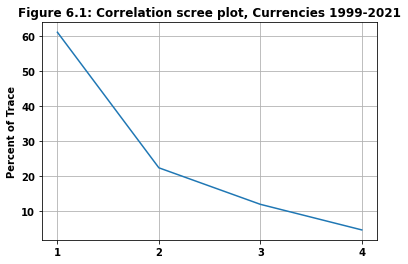

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import qrpm_funcs as qf

#get sorted eigenvalues and eigenvectors
def eig_get(M):
    evals,evecs=np.linalg.eigh(M)  #eigh is for symmetric M
    #Put the eigensystem in decreasing order of eigenvalues
    sortorder=evals.argsort()[::-1]
    evals=evals[sortorder]
    evecs=evecs[:,sortorder]
    return(evals,evecs)

#Get 4 currencies until the end of previous year.
firstday='1999-01-04'
lastday=qf.LastYearEnd()
seriesnames=['DEXSZUS','DEXUSUK','DEXJPUS','DEXUSEU']
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,
            startdate=firstday,enddate=lastday)
multipliers=[-1,1,-1,1]

lgdates,difflgs=qf.levels_to_log_returns(cdates,ratematrix,multipliers)

#compute correlation matrix and covariance matrix for later use
R=np.corrcoef(np.array(difflgs).T)
c=np.cov(np.array(difflgs).T)

#Make the scree plot
evals,evecs=eig_get(R)
plt.plot(range(1,5), list(evals*100/sum(evals)))

## Configure the graph
plt.title('Figure 6.1: Correlation scree plot, Currencies 1999-'+lastday[:4])
plt.ylabel('Percent of Trace')
plt.xticks(range(1,5),range(1,5))
plt.grid(True)
plt.show;

#Display shape for Marchenko-Pastur
T,n = np.shape(difflgs)
print('n=%2f, T=%2f' % (n, T))

#Display eigenvalues
print('Eigenvalues:',evals)

This plot shows a typical pattern where the eigenvalues drop in size: it is rare that they are close to equal. Usually as the size of the matrix increases, we see that a small number of eigenvalues account for most of the trace, after which there is an inflection point and the sizes of the eigenvalues drop sharply. This seems to be true of both covariance and correlation matrices: the correlation matrix $R=S^{-1}CS^{-1}$ will have different eigenvalues than the covariance matrix $C$, but if the standard deviations on the diagonal of $S$ don't cover too wide a range, $R$ will look like a scalar multiple of $C$ and will have similar eigenvalue patterns.

Financial econometricians have taken the dropoff in eigenvalues as evidence that the Arbitrage Pricing Theory is true. [Trzcinka 1986](https://www.jstor.org/stable/2328440) summarized his results as follows:
>We compute sample [stock market] covariance matrices of returns in sequentially larger portfolios of securities. Analyzing their eigenvalues, we find evidence that one eigenvalue dominates the covariance matrix indicating that a one-factor model may describe security pricing... We find that while only the first eigenvalue dominates the matrix, the first five eigenvalues are growing more distinct.

The dominance of the first eigenvalue seems to be replicable; other markets and other time periods than the ones used by Trzcinka &mdash; including our Figure 6.1 and yield curve data in Figure 3.10 &mdash; show a similar pattern. Trzcinka concluded that there wasn't strong evidence of another obvious inflection point after the first eigenvalue, but thought that there was weak evidence of an inflection point after the fifth eigenvalue.

Unfortunately a concentration in larger eigenvalues is not necessarily evidence of underlying factor structure: it may just be random. Suppose a $T\times n$ data matrix $X$ is populated randomly; each of the $nT$ entries is generated by an independent draw from a standard normal distribution. Marchenko and Pastur[$^6$](#six_footnotes) found the distribution of the sizes of eigenvalues of $C=\frac{1}{T}X^{\intercal}X$ as $n,T\to\infty$ with a constant ratio of $1<\frac{T}{n}<\infty$; it is heavily front-loaded.

If $G$ is the diagonal matrix of eigenvalues of a random standard covariance matrix, then in the limit the Marchenko-Pastur PDF of eigenvalues $g\in G$ is
$$f(g)=\frac{T}{n}\frac{\sqrt{(g_+-g)(g-g_-)}}{2\pi g}$$
where
$$g_{\pm}=(1\pm \sqrt{\frac{n}{T}})^2\label{marchenko_pastur}\tag{6.46}$$
For $g$ outside of the range $[g_-,g_+]$, the Marchenko-Pastur limit PDF is zero.

A standard random covariance matrix (i.e. one created from mean-$0$, variance-$1$ normal draws) is not exactly a correlation matrix since sampling noise may result in non-one diagonals. But the Marchenko-Pastur PDF of a standard random covariance matrix gives an idea of what pattern might be expected of a correlation matrix.

\eqref{eq:marchenko_pastur} gives the patterns shown in Figure 6.2:

Ratio = 0.000693
    Expected range from 0.95 to 1.05
Ratio = 0.500000
    Expected range from 0.09 to 2.91


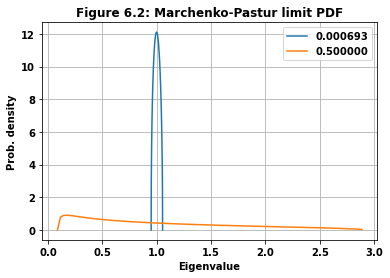

In [2]:
#Graph Marchenko-Pastur PDF

for ratio in [n/T,.5]:
    g_minus=(1-np.sqrt(ratio))**2
    g_plus=(1+np.sqrt(ratio))**2

    print('Ratio = %2.6f' % ratio)
    print('    Expected range from %4.2f to %4.2f' % (g_minus, g_plus))

    x=np.arange(g_minus,g_plus,(g_plus-g_minus)/100)
    y=[(1/ratio)*np.sqrt(np.abs((g_plus-g)*(g-g_minus)))/(2*np.pi*g) for g in x]
    label = '%2.6f' % ratio
    plt.plot(x, y, label=label)

## Configure the graph
plt.title('Figure 6.2: Marchenko-Pastur limit PDF')
plt.xlabel('Eigenvalue')
plt.ylabel('Prob. density')
plt.legend()
plt.grid(True)
plt.show;

Figure 6.2 shows two limiting PDFs: one for the (very small) ratio of ($n=4$) to (the number of data points used to create Figure 6.1); and another for a ratio of $.5$. Given that there are many years of data for only $4$ points in Figure 6.1, Marchenko-Pastur says that there's a lot of conviction about the eigenvalues all being close to $1$ if the matrix is random. (Recall that the eigenvalues of a correlation matrix must average to one because they must sum to the trace.)

On the other hand with relatively sparser data implied by a $.5$ ratio of assets to time periods, Marchenko-Pastur expects a more diffuse distribution of eigenvalues.

While Marchenko-Pastur is a limit distribution, one heuristic is to deem any eigenvalues below $g_+$ (which is about $1.5$ given the shape of the data used in Figure 6.1) as scree, i.e. noise. With that rule of thumb, only the largest of the four eigenvalues from the Figure 6.1 data is (highly!) significantly non-random. The others would be considered noise, so we would use the approximation $M_1=E_1G_1E_1^{\intercal}$ to estimate the out-of-sample matrix.

However, this heuristic doesn't preserve the trace of the original matrix $M$. One simple fix for this is to scale up the entire approximation matrix. If eigenvectors are cut off at $k<r$ by using the approximation $M_k=E_kG_kE_k^{\intercal}$, then the modified approximation $sM_k$ will have the right trace, where the scalar $s=\frac{trace(M)}{\sum_{i=1}^{k}g_i}$.

Another heuristic called the **`constant residual eigenvalue method`** (Lopez de Prado[$^7$](#six_footnotes)) is similar in spirit to Winsorization.[$^4$](#six_footnotes). This method averages the eigenvalues below a cutoff point: set $h_i=g_i$ for $i\leq k$ where $k$ is the cutoff point, and set $h_i=\frac{1}{r-k}\sum_{j=k+1}^r g_j$ for all $i>k$. Then the modfied approximation is $L_k=EH_kE^{\intercal}$, where H_k is the diagonal matrix of $h$s.

PCA's strength (as well as its weakness) is that it requires no judgment about the data. The Rosenberg-Marathe approach used in most commercial models requires judgment about which characteristics of a security are the important, lasting ones. If these judgments are right, then the model will do a good job predicting future covariance matrices. But as markets change, these models might not keep up. For example, most commercial models didn't have an Internet factor in the late 1990s, although the technology bubble (and its bursting) made Internet companies behave distinctly differently than other companies in that period.

Because PCA infers factors from the data, it is able to discover patterns that human analysts may not see. However, there are some disadvantages to this approach:
- PCA is backward-looking. It cannot "see" a pattern until it is in the data. Similarly, it cannot drop a pattern that is no longer relevant until it drops out of the data. For example, in the runup to the US invasion of Iraq in 2003, virtually the only factor that mattered in the US stock market was a security's relationship to the impending war. After the invasion of Iraq on March 20, 2003, this factor quickly became irrelevant. However a model with (say) a trailing 3-year data window would not know this for 3 years.
- The backward-looking problem would not be a problem if principal components were stable through time. However usually they are not &mdash; a PC that was present in the data in the last 3 years may disappear completely in the next three years. For this reason some practitioners use PCA as a forensic tool (helping to alert humans to patterns that may be emerging in the data) as opposed to a model.
- PCA factors are hard or impossible for humans to understand.

To see the time variation in eigenvalues and eigenvectors, let's compare the $4\times 4$ covariance matrix using the data behind Figure 6.1 (taken over the period 1999 (when the Euro began) to the most recent yearend) with the same currencies from the turbulent year 2008.

In [3]:
#Display the 4x4 covariance matrix
np.set_printoptions(precision=4,floatmode='fixed',sign=' ')
print('1999-'+lastday[:4]+' covariance matrix (Cfull): (%d days)' % len(difflgs))
print('     CHF     GBP     JPY     EUR')
for i in range(4):
    print(c[i]*10000)

#Compute 2008 covariance matrix
s2008=lgdates.index('2008-01-02')
e2008=lgdates.index('2008-12-31')
c2008=np.cov(np.array(difflgs[s2008-1:e2008+1]).T)
#Display the 4x4 covariance matrix
print('2008 covariance matrix (C2008):')
for i in range(4):
    print(c2008[i]*10000)

1999-2021 covariance matrix (Cfull): (5769 days)
     CHF     GBP     JPY     EUR
[ 0.4334  0.1908  0.1594  0.3080]
[ 0.1908  0.3449  0.0526  0.2173]
[ 0.1594  0.0526  0.3877  0.1069]
[ 0.3080  0.2173  0.1069  0.3498]
2008 covariance matrix (C2008):
[ 0.9045  0.3453  0.3816  0.6867]
[ 0.3453  0.9142 -0.2797  0.5875]
[ 0.3816 -0.2797  0.9572  0.0110]
[ 0.6867  0.5875  0.0110  0.8044]


The effects of the financial crisis in 2008 are clear: the diagonals of C2008 are larger than the diagonals of Cfull by about a factor of two &mdash; i.e. volatility was much higher in 2008.

The eigenvalues and eigenvectors for Cfull were:

In [4]:
#Display the eigenvalues
evals,evecs=eig_get(c)
print('Full period eigenvalues times 10**6:')
print(evals*1000000)

#Display the eigenvectors
print('Eigenvector (column) matrix:')
labels=['CHF','GBP','JPY','EUR']
for i in range(4):
    print(labels[i],evecs[i])

Full period eigenvalues times 10**6:
[ 92.9893  33.8204  17.7947   6.9809]
Eigenvector (column) matrix:
CHF [-0.6212 -0.0044  0.5418 -0.5662]
GBP [-0.4392 -0.4192 -0.7575 -0.2398]
JPY [-0.3348  0.8861 -0.3150  0.0590]
EUR [-0.5560 -0.1975  0.1828  0.7864]


The first column of the eigenvector matrix is the one associated with the largest eigenvalue. All the entries are of the same sign and are roughly the same order of magnitude. There's no guarantee that an eigenvector will have any intuitive meaning, but in this case it's pretty clear what the largest factor is: it's the US dollar, since all these exchange rates were versus the US dollar.

The second column of the eigenvector matrix might be Europe vs. Japan, but we're just guessing. We only have 4 items in our universe here. Imagine if there were 4000 items: it would be very tough to find an intuitive explanation of 4000 numbers.

Here's the eigensystem of the 2008 covariance matrix:

In [5]:
#get eigenvalues and eigenvectors of the 2008 matrix
evals2008,evecs2008=eig_get(c2008)

#Display the 2008 eigenvalues
print('2008 eigenvalues times 10**6:')
print(evals2008*1000000)

#Display the 2008 eigenvectors
print('2008 eigenvector (column) matrix:')
for i in range(4):
    print(labels[i],evecs2008[i])

2008 eigenvalues times 10**6:
[ 196.6205  125.9944   27.9513    7.4675]
2008 eigenvector (column) matrix:
CHF [-0.5949  0.3290  0.3950 -0.6178]
GBP [-0.5133 -0.4496 -0.7044 -0.1956]
JPY [-0.0894  0.8280 -0.5177  0.1960]
EUR [-0.6120 -0.0638  0.2824  0.7359]


The overall volatility has gone up a lot as previously noted. The first principal component now seems to be mostly European currencies vs. the dollar, whose role as a safe haven currency was even more important in 2008. The second principal component has become more important than in the full matrix (i.e. eigenvalue is larger both on an absolute basis and as a percentage of the total). The second PC now appears to be currencies that were considered safe havens (Swissie and yen) vs. less safe-haven currencies (pound and euro).

Often PCA is used for noise reduction. The sequence of approximations $M_1,\dots,M_r$ to a matrix $M$ noted in \eqref{eq:eigenvector_optimal_property} uses successively more eigenvalues and eigenvectors. For example, we might have concluded after looking at the eigendecomposition of the $4\times4$ currency covariance matrices that only the first two components were significant, so $M_2=E_2G_2E_2^{\intercal}$ would be a good compromise to avoid overfitting past data. The premise is that the biggest eigenvectors, or at least some linear combination of them, are the lasting explanations that will continue to predict out-of-sample behavior.

The code in the next cell computes covariance matrices based on fewer eigenvalues as directed by the user. Various heuristics for noise reduction are used.

In [6]:
#Compute and display currency covariance matrix
#based on fewer principal components with various heuristics

def display_trunc(matrix,n_2_use=2):
    #Display matrix with truncated eigensystem
    
    #Round to integer
    num_2_use=int(n_2_use)
    
    evals,evecs=eig_get(matrix)
    
    #Form truncated diagonal matrix G of eigenvalues
    g_trunc=np.diag(evals)[:num_2_use]
    del_cols=np.arange(num_2_use,len(evals))
    g_trunc=np.delete(g_trunc,del_cols,1)

    #Form truncated matrix E_k of eigenvectors
    e_trunc=np.delete(evecs,del_cols,1)

    m_trunc=(e_trunc @ g_trunc) @ e_trunc.T
    m_scale=np.multiply(np.matrix.trace(matrix)/np.matrix.trace(m_trunc),m_trunc)
    
    #Constant residual
    h=np.copy(evals)
    if n_2_use >= 4:
        residual=0
    else:
        residual=np.sum(evals[n_2_use:])/(4-n_2_use)
    for i in range(n_2_use,4):
        h[i]=residual
    m_constres=(evecs @ np.diag(h)) @ evecs.T
        
    print('Original matrix:')
    print('     CHF     GBP     JPY     EUR')
    for i in range(4):
        print(matrix[i]*10000)
    print('Truncated matrix:')
    for i in range(4):
        print(m_trunc[i]*10000)
    print('Scaled truncated matrix:')
    for i in range(4):
        print(m_scale[i]*10000)
    print('Constant residual matrix:')
    for i in range(4):
        print(m_constres[i]*10000)
        
while True:
    print("Input #eigenvectors to use (1-4), 0 to stop")
    n_to_use=int(input())
    if n_to_use<1:
        break
    display_trunc(c,n_to_use)

Input #eigenvectors to use (1-4), 0 to stop


 2


Original matrix:
     CHF     GBP     JPY     EUR
[ 0.4334  0.1908  0.1594  0.3080]
[ 0.1908  0.3449  0.0526  0.2173]
[ 0.1594  0.0526  0.3877  0.1069]
[ 0.3080  0.2173  0.1069  0.3498]
Truncated matrix:
[ 0.3588  0.2543  0.1921  0.3215]
[ 0.2543  0.2388  0.0111  0.2551]
[ 0.1921  0.0111  0.3698  0.1139]
[ 0.3215  0.2551  0.1139  0.3007]
Scaled truncated matrix:
[ 0.4289  0.3040  0.2296  0.3843]
[ 0.3040  0.2855  0.0133  0.3049]
[ 0.2296  0.0133  0.4421  0.1362]
[ 0.3843  0.3049  0.1362  0.3594]
Constant residual matrix:
[ 0.4349  0.2203  0.1668  0.2786]
[ 0.2203  0.3170  0.0389  0.2146]
[ 0.1668  0.0389  0.3825  0.1125]
[ 0.2786  0.2146  0.1125  0.3814]
Input #eigenvectors to use (1-4), 0 to stop


 0


The matrices don't look very different by the time two PCs are used, confirming at least intuitively that the significant movements are in the earlier principal components.

Current commercial risk models may use a hybrid approach, where a specified factor model like \eqref{eq:fama_french_carhart} &mdash; or the richer 100-factor models used in practice &mdash; is applied first. The residuals $\epsilon_s$ from \eqref{eq:fama_french_carhart} (or its commercial big brother) are computed for each security in each time period, typically for sixty months. The residuals are then used to form a residual covariance matrix, and PCA is applied to that matrix. If it looks like there is a large common factor in the residual covariance, the model \eqref{eq:fama_french_carhart} must be misspecified. This process can be used as a forensic tool to guide intuition to find missing factors, or it can be used to add residual PCA factors to the risk model.

# Chapter 6 Footnotes #
<a name="six_footnotes"></a>

$^1$ Gottfreid Leibniz, one of the inventors of calculus, was also a philosopher who stated that we lived in the best of all possible worlds, i.e. that the world is optimal in some sense. This view was most famously mocked by Voltaire, whose satirical novel _Candide_ contained a pathologically optimistic character, Dr. Pangloss, who subscribed to Leibniz's philosophy even while undergoing a violently suboptimal set of disasters. Most active practitioners find the pure EMH to be as out-of-touch as Dr. Pangloss.
<br>

$^2$ There is a vast academic literature, mostly from the early 1970s, attempting to test the CAPM. [Roll 1977](https://doi.org/10.1016/0304-405X(77)90009-5) eviscerated most of this work (including his own), saying of CAPM that "(a) No correct and unambiguous test of the theory has appeared in the literature; and (b) there is practically no possibility that such a test can be accomplished in the future." Current work focuses on exploiting the failings of CAPM; for example a popular approach is called [Betting against Beta.](https://doi.org/10.1016/j.jfineco.2013.10.005)
<br>

$^3$ [Jack Treynor](https://www.q-group.org/jack-treynor-prize/) appears to have been the first to develop something like CAPM. William Sharpe says that after writing his own paper on the subject, he "...learned that Mr. Jack L. Treynor, of Arthur D. Little Inc., had independently developed a model similar in many respects to the one described here. Unfortunately Mr. Treynor's excellent work on this subject is, at present, unpublished."
<br>

$^4$ Winsorization (named after biostatistician Charles Winsor) is a truncation process by which outlying data is moderated. A parametric version of the process caps observations at some maximum or minimum numerical amount, so for example any observation over 4.5 would be deemed to equal 4.5. A non-parametric version sorts observations from lowest to highest and then sets (say) the lowest and second-lowest observations equal to the third-lowest observation.
<br>

$^5$ If $M$ is a correlation matrix, then an approximation $M_i$ using fewer eigenvectors will not itself be a correlation matrix: the diagonal will not consist of ones. This can be repaired by treating $M_i$ as if it was a covariance matrix and setting $R_i=\sqrt{diag(M_i)^{-1}}M_i\sqrt{diag(M_i)^{-1}}$, but then $R_i$ will have a different eigensystem than $M_i$. Analysts using this method should take care that the result is sensible.
<br>

$^6$ Nicu and Speicher, _Lectures on the Combinatorics of Free Probability_, https://www.google.com/search?tbs=bks:1&q=isbn:0521858526, p. 368.
<br>

$^7$ L&oacute;pez de Prado, Marcos, _Machine Learning for Asset Managers_, Cambridge Elements, Quantitative Finance, April 2020.